# Faster R-CNN Training using Tensorflow
___

### Before started!
- navigate to `Runtime` menu, and choose `change runtime type`,
- then, change `hardware acceleration` to `GPU`
- click `connect` button in top-right colab

# 1. Install Library
### 1.A. Install Tensorflow

In [1]:
pip install tensorflow_gpu==1.15

     |████████████████████████████████| 411.5MB 42kB/s 
     |████████████████████████████████| 512kB 47.8MB/s 
     |████████████████████████████████| 3.8MB 50.0MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=398b03e7cc733b90fabffe9db17c7d6210fc17219447d6e95c192e8c15df0da4
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorboard~=2.4, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorflow-estimator<2.5.0,>=2.4.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing instal

### 1.B. Install Other Library & Clone Tensorflow Model

In [2]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython tf_slim
!pip install -q pycocotools
!pip install -q Cython contextlib2 pillow lxml matplotlib

!git clone https://github.com/tensorflow/models.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-tk is already the newest version (2.7.17-1~18.04).
The following additional packages will be installed:
  python-bs4 python-chardet python-html5lib python-olefile
  python-pkg-resources python-six python-webencodings
Suggested packages:
  python-genshi python-lxml-dbg python-lxml-doc python-pil-doc python-pil-dbg
  python-setuptools
The following NEW packages will be installed:
  python-bs4 python-chardet python-html5lib python-lxml python-olefile
  python-pil python-pkg-resources python-six python-webencodings
0 upgraded, 9 newly installed, 0 to remove and 17 not upgraded.
Need to get 1,615 kB of archives.
After this operation, 8,907 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python-bs4 all 4.6.0-1 [67.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd

### 1.C. Build Tensorflow Model Builder

In [3]:
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.
%set_env PYTHONPATH=/content/models/research:/content/models/research/slim

import os
os.environ['PYTHONPATH'] += ":/content/models"

import sys
sys.path.append("/content/models")
!python object_detection/builders/model_builder_test.py

/content/models/research
env: PYTHONPATH=/content/models/research:/content/models/research/slim


# 2. Prepare Dataset
### 2.A Upload and extract dataset.
- upload `dataset.zip` using this script,
- `dataset.zip` is created by running `dataset_builder.ipynb` from this repository ([ObjectDetection-Tensorflow](https://github.com/Muhammad-Yunus/ObjectDetection-Tensorflow)) in your local computer.

In [4]:
%cd /content

import shutil
from zipfile import ZipFile
from google.colab import files
from os import path

print("Upload `dataset.zip` to colab :")
uploaded = files.upload()
  
for fileName, data in uploaded.items():
  with open('dataset.zip', 'wb') as f:
    f.write(data)
    f.close()
    print('saved dataset (.zip) file ' + fileName)

ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

/content
Upload `dataset.zip` to colab :


Saving dataset.zip to dataset.zip
saved dataset (.zip) file dataset.zip
Extracted zip file dataset.zip


### 2.B. Prepare Dataset 
- Convert XML PASCAL VOC to CSV
- Create TF_Record from generated CSV

In [5]:
%cd /content/dataset

!python xml_to_csv.py

/content/dataset
Successfully converted xml to csv.
Successfully converted xml to csv.


- edit `class_text_to_int()` function in `generated_tfrecord.py` with label and index label we have.

In [6]:
%cd /content/dataset

!python generate_tfrecord.py --csv_input=data/train_labels.csv  --output_path=data/train.record --image_dir=images/train

!python generate_tfrecord.py --csv_input=data/test_labels.csv  --output_path=data/test.record --image_dir=images/test

/content/dataset


W0214 04:39:03.898896 140306211837824 module_wrapper.py:139] From generate_tfrecord.py:90: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0214 04:39:03.937001 140306211837824 module_wrapper.py:139] From generate_tfrecord.py:49: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/dataset/data/train.record


W0214 04:39:06.079907 140134411192192 module_wrapper.py:139] From generate_tfrecord.py:90: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0214 04:39:06.092171 140134411192192 module_wrapper.py:139] From generate_tfrecord.py:49: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/dataset/data/test.record


# 3. Download pretrained model

- Pretrained model (Tensorflow 1 Model Zoo) : [[tensorflow github](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md)]


In [7]:
%cd /content/dataset
%rm -rf models

%mkdir models
%mkdir models/inference_graph

/content/dataset


In [8]:
%cd /content/dataset/models

import os
import shutil
import glob
import urllib.request
import tarfile

MODEL = 'faster_rcnn_inception_v2_coco_2018_01_28'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = 'faster_rcnn_inception_v2'

with urllib.request.urlopen(DOWNLOAD_BASE+MODEL_FILE) as response, open(MODEL_FILE, 'wb') as out_file:
  shutil.copyfileobj(response, out_file)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/dataset/models


# 4. Copy & Edit Config File
- copy config model to `data/` folder

In [9]:
CONFIG_NAME = "faster_rcnn_inception_v2_coco.config"
shutil.copy(
    "/content/models/research/object_detection/samples/configs/" + CONFIG_NAME, 
    "/content/dataset/data/")

'/content/dataset/data/faster_rcnn_inception_v2_coco.config'

- open & edit config file in `/content/dataset/data/faster_rcnn_inception_v2_coco.config`, 

- navigate to line 8, change  `model`>`faster_rcnn`>`num_classes` to number of class on uploaded dataset (e.g/ 2).
- navigate to line 85, change `train_config`>`num_steps` to number of training step (e.g/ 2000)
- navigate to line 107,
```
fine_tune_checkpoint: "/Path to the pre-trained models/model.ckpt"
```
- change to 
```
/content/dataset/models/faster_rcnn_inception_v2/model.ckpt
```

- navigate to line 120,
```
train_input_reader: {
  tf_record_input_reader {
  input_path: "/Path to the tfrecord/train.record"
  }
  label_map_path: "/Path to label map/object-detection.pbtxt"
}
```
- change `input_path` to,
```
/content/dataset/data/train.record
```
- change `label_map_path` to,
```
/content/dataset/data/object-detection.pbtxt
```

- navigate to line 134,
```
eval_input_reader: {
tf_record_input_reader {
input_path: "/Path to the tfrecord/test.record"
}
label_map_path: "/Path to label map/object-detection.pbtxt"
}
```
- change `input_path` to,
```
/content/dataset/data/test.record
```
- change `label_map_path` to,
```
/content/dataset/data/object-detection.pbtxt
```

# 5. Train model
Make and set train directory num_train_steps and num_eval_steps values to change train and eval steps in training process.



In [10]:
!cp /content/models/research/object_detection/legacy/train.py /content/models/research/object_detection

In [16]:
%cd /content/models/research/object_detection/
%rm -rf training/*

!python train.py \
  --logtostderr \
  --train_dir=training/ \
  --pipeline_config_path=/content/dataset/data/faster_rcnn_inception_v2_coco.config

Streaming output truncated to the last 5000 lines.
INFO:tensorflow:global step 17507: loss = 0.0396 (0.176 sec/step)
I0214 05:48:36.761261 139981114623872 learning.py:512] global step 17507: loss = 0.0396 (0.176 sec/step)
INFO:tensorflow:global step 17508: loss = 0.0474 (0.169 sec/step)
I0214 05:48:36.932147 139981114623872 learning.py:512] global step 17508: loss = 0.0474 (0.169 sec/step)
INFO:tensorflow:global step 17509: loss = 0.0110 (0.164 sec/step)
I0214 05:48:37.097072 139981114623872 learning.py:512] global step 17509: loss = 0.0110 (0.164 sec/step)
INFO:tensorflow:global step 17510: loss = 0.0179 (0.163 sec/step)
I0214 05:48:37.261524 139981114623872 learning.py:512] global step 17510: loss = 0.0179 (0.163 sec/step)
INFO:tensorflow:global step 17511: loss = 0.0150 (0.163 sec/step)
I0214 05:48:37.425583 139981114623872 learning.py:512] global step 17511: loss = 0.0150 (0.163 sec/step)
INFO:tensorflow:global step 17512: loss = 0.0309 (0.164 sec/step)
I0214 05:48:37.590746 139981

# 5. Tensorboard Training Visualisation + Ngrok
- **TensorBoard** is a tool for providing the `measurements` and `visualizations` needed during the machine learning workflow. It enables `tracking` experiment `metrics` like `loss` and `accuracy`, visualizing the model graph, projecting embeddings to a lower dimensional space, and much more.
- **ngrok** is secure `introspectable tunnels` to `localhost` webhook development tool and debugging tool.

In [34]:
%cd /content/models/research/object_detection/training/
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

/content/models/research/object_detection/training
--2021-02-14 06:39:14--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.23.32.39, 34.196.72.78, 52.55.225.227, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.23.32.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.13M  38.3MB/s    in 0.3s    

2021-02-14 06:39:15 (38.3 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [21]:
LOG_DIR = '/content/models/research/object_detection/training/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [22]:
get_ipython().system_raw('./ngrok http 6006 &')

In [23]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://5dc7a1bd125b.ngrok.io


- close ngrok - tensorboard for training log visualization

In [40]:
!ps aux | grep ngrok

root        1103  0.1  0.0      0     0 ?        Z    04:55   0:07 [ngrok] <defunct>
root        2049  0.0  0.0      0     0 ?        Z    06:03   0:00 [ngrok] <defunct>
root        2672  0.5  0.0      0     0 ?        Z    06:39   0:00 [ngrok] <defunct>
root        2702  0.0  0.0  39200  6428 ?        S    06:40   0:00 /bin/bash -c ps aux | grep ngrok
root        2704  0.0  0.0  38576  5076 ?        S    06:40   0:00 grep ngrok


In [39]:
!kill -9 2672  #<---ngrok tensorboard train pid--->

# 6 Tensor Board Eval Visualization

In [26]:
%cd /content/models/research/object_detection/
!cp /content/models/research/object_detection/legacy/eval.py /content/models/research/object_detection

/content/models/research/object_detection


In [27]:
!pip install lvis

- run evaluation metric (`eval.py`) to find **mAP** of object detection model,

In [29]:
%rm -rf eval/*

!python eval.py \
  --logtostderr \
  --pipeline_config_path=/content/dataset/data/faster_rcnn_inception_v2_coco.config \
  --checkpoint_dir=training/ \
  --eval_dir=eval/

Streaming output truncated to the last 5000 lines.
W0214 06:11:46.256670 140549745547136 object_detection_evaluation.py:1212] image b'ironman_10.jpg' has already been added to the detection result database
W0214 06:11:46.312063 140549745547136 object_detection_evaluation.py:324] Image with id b'ironman_11.jpg' already added.
W0214 06:11:46.312217 140549745547136 object_detection_evaluation.py:1146] image b'ironman_11.jpg' has already been added to the ground truth database.
W0214 06:11:46.312294 140549745547136 object_detection_evaluation.py:1212] image b'ironman_11.jpg' has already been added to the detection result database
W0214 06:11:46.380414 140549745547136 object_detection_evaluation.py:324] Image with id b'ironman_12.jpg' already added.
W0214 06:11:46.380589 140549745547136 object_detection_evaluation.py:1146] image b'ironman_12.jpg' has already been added to the ground truth database.
W0214 06:11:46.380681 140549745547136 object_detection_evaluation.py:1212] image b'ironman_12

In [41]:
LOG_DIR = '/content/models/research/object_detection/eval/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6007 &'
    .format(LOG_DIR)
)

In [42]:
get_ipython().system_raw('./ngrok http 6007 &')

In [43]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://dc76ee4ff2ab.ngrok.io


# 6. Export trained model

Export trained model with highest step number in filename.
- change `model.ckpt-xxxxx` with `xxxxx` is number of step in trainingphase.

In [45]:
%cd /content/models/research/object_detection
%rm -rf inference_graph/*

!python export_inference_graph.py \
  --input_type image_tensor \
  --pipeline_config_path /content/dataset/data/faster_rcnn_inception_v2_coco.config \
  --trained_checkpoint_prefix /content/models/research/object_detection/training/model.ckpt-20000 \
  --output_directory /content/dataset/models/inference_graph

/content/models/research/object_detection
Instructions for updating:
Please use `layer.__call__` method instead.
W0214 06:43:18.848572 139723347056512 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:2802: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Scale of 0 disables regularizer.
I0214 06:43:20.076776 139723347056512 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
I0214 06:43:20.220123 139723347056512 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0214 06:43:20.220542 139723347056512 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0214

# 7. Test Model (Inferencing)

- upload arial font (`arial.ttf`) from cloned repo ([ObjectDetection-Tensorflow](https://github.com/Muhammad-Yunus/ObjectDetection-Tensorflow)) using script below,

In [47]:
uploaded = files.upload()
  
for name, data in uploaded.items():
  with open('/content/models/research/object_detection/utils/arial.ttf', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)

Saving arial.ttf to arial.ttf
saved file arial.ttf


- open `/content/models/research/object_detection/utils/visualization_utils.py` and navigate to line `212`, change *font size* to a proper value (e.g/ 50).
    ```
    try:
      font = ImageFont.truetype('arial.ttf', 50)
    except IOError:
      font = ImageFont.load_default()
    ```

- Upload image test

In [58]:
%cd /content
# upload image from local computer to colab

from google.colab import files
from os import path

uploaded = files.upload()
  
for name, data in uploaded.items():
  with open('image1.jpg', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)

/content


Saving ironman_48.jpg to ironman_48.jpg
saved file ironman_48.jpg


- predict on `image1.jpg`

/content/models/research/object_detection


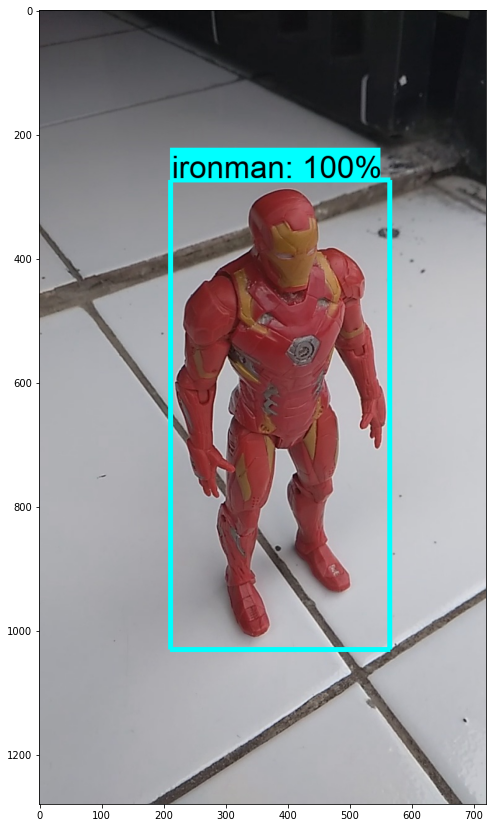

In [59]:
%cd /content/models/research/object_detection

# [NOTE!] this sample implementation using Tensorflow ver 1.14

import os
import sys
import numpy as np
from PIL import Image
import tensorflow as tf
from matplotlib import pyplot as plt

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

from utils import label_map_util
from object_detection.utils import ops as utils_ops
from utils import visualization_utils as vis_util
import importlib
importlib.reload(vis_util)

# This is needed to display the images.
%matplotlib inline

# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/content/dataset/models/inference_graph' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/content/dataset/data', 'object-detection.pbtxt')

NUM_CLASSES = 2 #[TODO!] change to number of training class

TEST_IMAGE_PATHS = [ os.path.join('/content/', 'image{}.jpg'.format(i)) for i in range(1, 2) ]

IMAGE_SIZE = (8, 17)

# load frozen inference graph
frcnn_graph = tf.Graph()
with frcnn_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
# load label map
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


# PIL image to numpy array converter
def PIL_to_numpy(image):
  (w, h) = image.size

  return np.array(image.getdata()).reshape((h, w, 3)).astype(np.uint8)

def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
          
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
                                      'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict


# -------------- main block --------------
for image_path in TEST_IMAGE_PATHS:
  # read image using PIL
  image = Image.open(image_path)
  image_np = PIL_to_numpy(image)

  # predict image
  output_dict = run_inference_for_single_image(image_np, frcnn_graph)

  # draw bousing box using `vis_util`
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  
  # show image
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  

# 8. Zip  & Download Inference Graph

In [60]:
%cd /content/dataset/models
!zip -r inference_graph.zip inference_graph

from google.colab import files
files.download("inference_graph.zip")

/content/dataset/models
  adding: inference_graph/ (stored 0%)
  adding: inference_graph/model.ckpt.meta (deflated 94%)
  adding: inference_graph/checkpoint (deflated 42%)
  adding: inference_graph/model.ckpt.data-00000-of-00001 (deflated 7%)
  adding: inference_graph/pipeline.config (deflated 68%)
  adding: inference_graph/frozen_inference_graph.pb (deflated 8%)
  adding: inference_graph/saved_model/ (stored 0%)
  adding: inference_graph/saved_model/variables/ (stored 0%)
  adding: inference_graph/saved_model/saved_model.pb (deflated 8%)
  adding: inference_graph/model.ckpt.index (deflated 70%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

___
# Source :
- https://muchamadsyaiffudin.medium.com/object-detection-with-custom-dataset-faster-rcnn-on-google-colab-33b373a625eb
- https://colab.research.google.com/drive/1skc-BJ6HzuaIRbi3diP86lRnCTcNCond?usp=sharing